# Markowitz Portfolio Optimization
A framework to model investing in the stock market. It's a multi-objective problem.<br>

We wish to find the right blend of stocks that meet one of the following criteria:
<ol>
    <li>maximize expected return - $\lambda$ risk</li>
    <li>maximzie expected return s.t. risk $\leq s^{max}$</li>
    <li>minimize risk s.t. expected return $\ge r^{min}$</li>
</ol>
   
Where $s^{max}$ and $r^{min}$ are arbitrary thresholds. 
    
    
### Optimization problem statement
Given \$1000, how much would you invest in each of the tree stocks `MSFT`, `V`, `WMT` so as to:
* have one month expected return of at least a given threshold
* minimize the risk (variance) of the porfolio return

<b>decision:</b> investment in each stock<br>
<b>alternatives:</b> any investment that meets the budget and the minimum expected return requirement<br>
<b>best:</b> minimize variance

### Contraints:
$\sum_{i=1}^3 x_i \le 1000$ or $\mathbf{e}^T\mathbf{x} \le 1000$

Return on portfolio:

$\sum_{i=1}^3 \tilde{r_i} x_i$

where $\tilde{r_1}$ is a vector of random returns

### Expected Return:
$\sum_{i=1}^3 \bar{r_i} x_i = \hat{\mathbf{r}}^T\mathbf{x}$

### Objective:
$Var[\sum_{i=1}^3 \tilde{r_i} x_i] = \mathbf{x}^TQ\mathbf{x}$

where $Q_{3\times3}$ is the variance-covariance matrix. The diagonal of the matrix denotes the `variance` of each stock, and the non-diagonals denote the `covariance`

In [91]:
import pandas as pd
import numpy as np
import os
import cvxpy as cp # convex optimization library
import scipy.optimize as spo
import matplotlib.pyplot as plt
plt.style.use("seaborn")

os.listdir("../../data")
df = pd.read_csv("../../data/monthly_prices.csv", index_col=0)

No handles with labels found to put in legend.


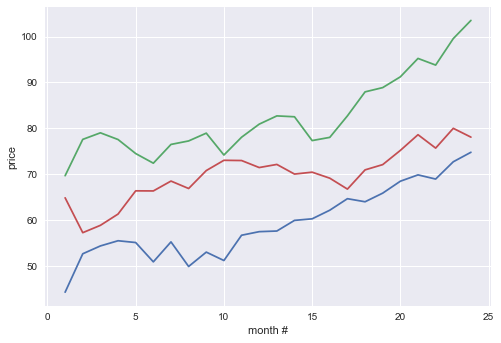

In [99]:
plt.plot(df[["MSFT", "V", "WMT"]]);
plt.xlabel("month #")
plt.ylabel("price");
plt.legend();

In [150]:
df_returns = df[["MSFT", "V", "WMT"]].rolling(2).apply(lambda x: (x[1] - x[0]) / x[0])
df_returns.drop(index=1, axis=0, inplace=True)

       MSFT         V       WMT
1       NaN       NaN       NaN
2  0.189336  0.113695 -0.117212
3  0.032485  0.018433  0.027952
4  0.020791 -0.018479  0.041808
5 -0.007030 -0.039458  0.082545


/Users/Ipanema/src/gstvolvr/notebooks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


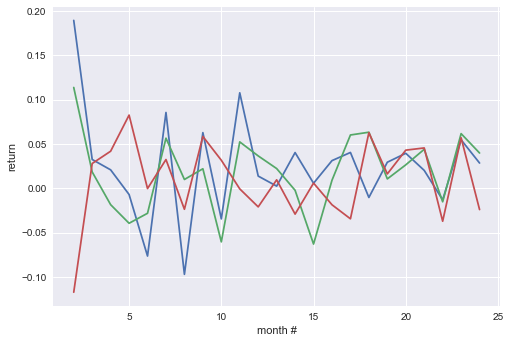

In [96]:
plt.plot(df_returns)
plt.xlabel("month #");
plt.ylabel("return");

### Estimating parameters
* We need to expected values of the covariances of the end-of-month returns of the `3` stocks
* <b>Assumption:</b> the monthly stock returns have a `stationary` probability distribution, and the historical data is a sample from this distribution. 
* We can then estimate the expected values and covariances of this monthly return distribution through statistical analysis of historical data. 

In [103]:
df_returns.mean(axis=0)

MSFT    0.024611
V       0.018237
WMT     0.009066
dtype: float64

In [207]:
C = df_returns[["MSFT", "V", "WMT"]].cov().values # covariance matrix
r = df_returns.mean(axis=0) # mean return 
symbols = df.columns

print("Expected return: ")
print(r.apply(lambda x: f"{x * 100: 0.2f}%"), end="\n\n")
print("Risk: ")
print(np.diag(C) ** 0.5, end="\n\n")
print("Average returns: ")
print(r.apply(lambda x: f"{x * 100: 0.2f}%"), end="\n\n")
print(f"Required return: {req_return * 100:0.2f}%")

n = len(symbols)
x = cp.Variable(n)
# req_return = r.max()
req_return = 0.02
ret = r.values.T*x
risk = cp.quad_form(x, C)
constraints = [cp.sum(x) == 1, ret >= req_return, x >= 0]
prob = cp.Problem(cp.Minimize(risk), constraints)
prob.solve()

for i in range(len(symbols)):
    print(f"{symbols[i]} = {x.value[i]:0.2f}")
print(f"Return: {ret.value:0.2f}")
print(f"Risk: {risk.value:0.2f}")

Expected return: 
MSFT     2.46%
V        1.82%
WMT      0.91%
dtype: object

Risk: 
[0.05804007 0.04280681 0.04446075]

Average returns: 
MSFT     2.46%
V        1.82%
WMT      0.91%
dtype: object

Required return: 2.46%
MSFT = 0.58
V = 0.20
WMT = 0.21
Return: 0.02
Risk: 0.00


In [179]:
df_returns[["MSFT", "V", "WMT"]].cov()

,MSFT,V,WMT
MSFT,0.003369,0.001633,-0.000752
V,0.001633,0.001832,-0.000563
WMT,-0.000752,-0.000563,0.001977


In [153]:
C

array([[ 0.00336865,  0.0016328 , -0.00075249],
       [ 0.0016328 ,  0.00183242, -0.00056339],
       [-0.00075249, -0.00056339,  0.00197676]])

### Resources:
* [ISyE6669 — Module 2](https://courses.edx.org/courses/course-v1:GTx+ISYE6669+2T2019/courseware/047232c28195423c982753be1ca40376/0882de288c9d4fd98ed7f5ea0e746196/?child=first)

In [75]:
x.shape

(3,)

In [82]:
Q.shape

(24, 3)

In [86]:
x, np.dot(Q, x)

TypeError: prod() got multiple values for argument 'axis'